$$\text{
Importing the Necessary Libraries
}
$$

In [49]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist


$$\text{
Setting Global Varables
}
$$

In [50]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 32
BATCH_SIZE = 32

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




$$\text{
    Loading the data
}
$$

In [51]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

In [52]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [53]:
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


$$
\text{
    Plot the Images
}$$

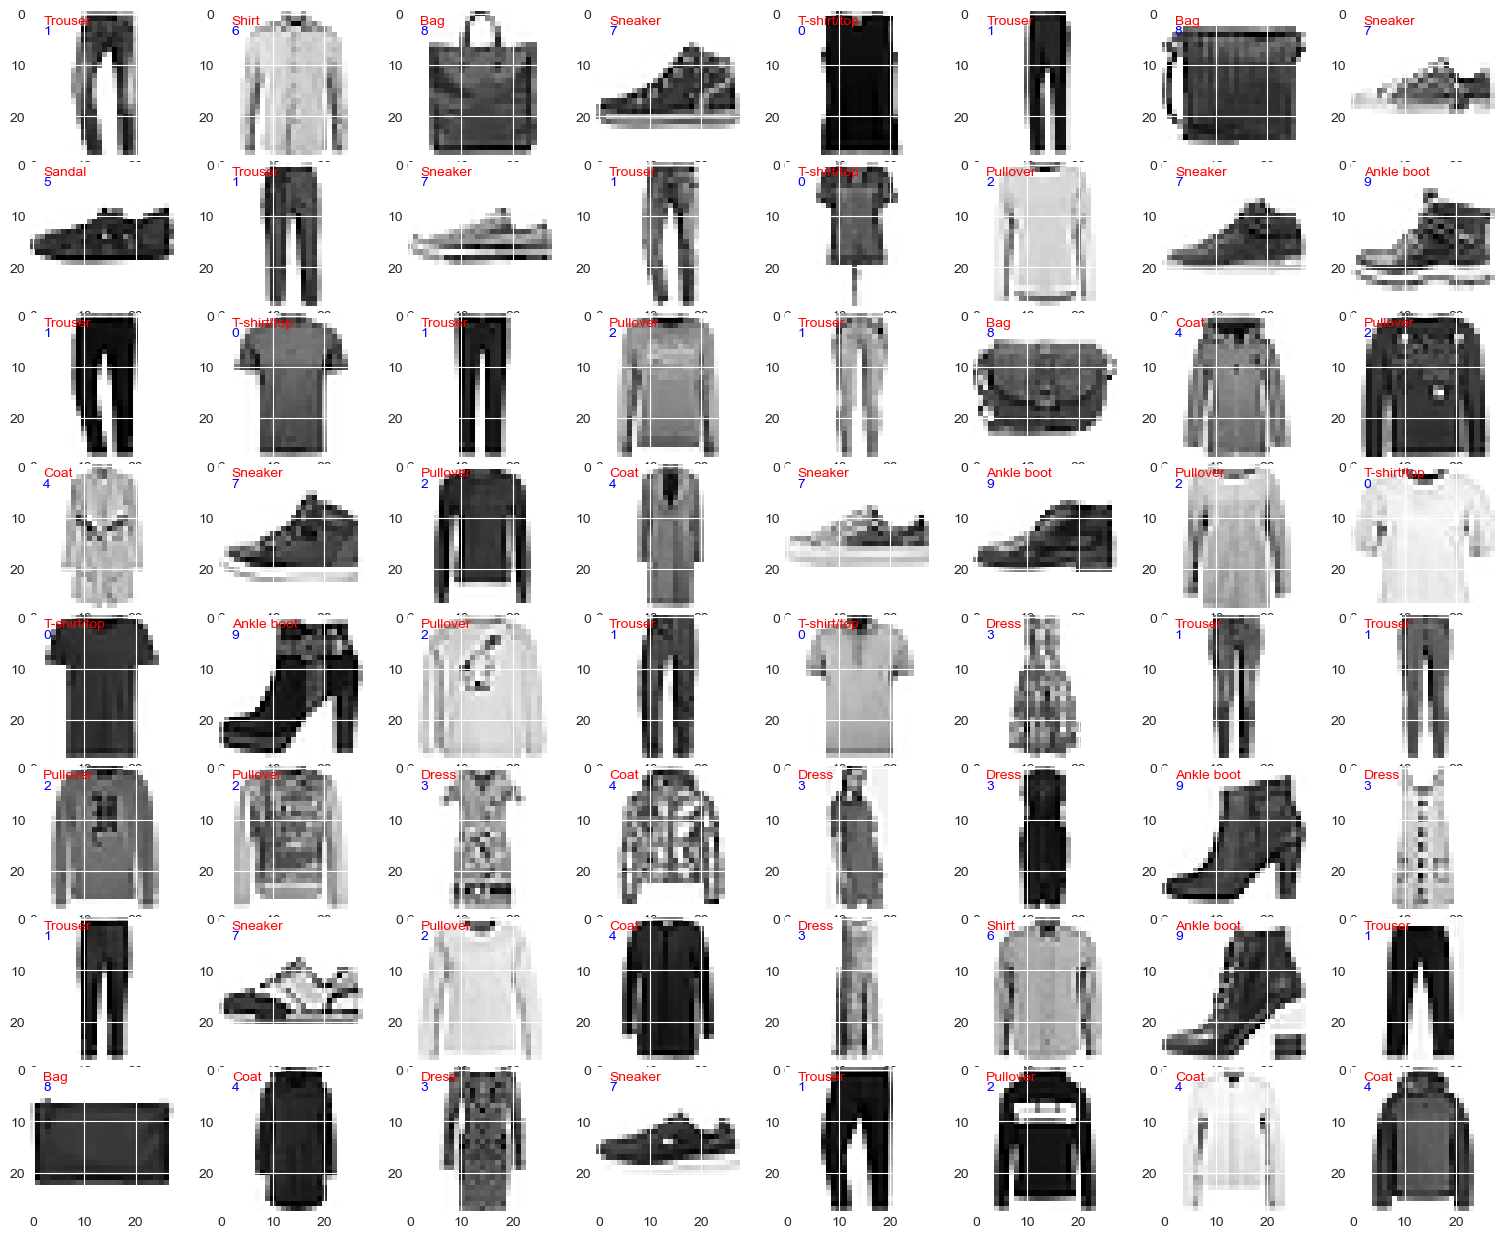

In [54]:
no_rows = 8
no_cols = 8

plot_df = train_df.sample(no_rows*no_cols)

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

for idx, row in plot_df.iterrows():
    i += 1
    image  = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(no_rows, no_cols, i)
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
    ax.text(2,4, str(row.values[0]),color='b', fontsize=10)
    ax.text(2,2, class_names[row.values[0]],color='r', fontsize=10)

plt.show()  


$$\text{
    Train Test Split
}
$$

In [55]:
X_data = train_df.drop(columns=['label'], axis=1).to_numpy()
y_data = train_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid = valid_df.drop(columns=['label'], axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((48000, 784), (12000, 784), (48000,), (12000,))

$$\text{
    Scaling the Dataset
}
$$

In [56]:
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

$$
\text{
Converting to dataset for batch processing instead of all data training at once
}
$$

In [57]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))

type(train_ds), type(test_ds), type(valid_ds)

(tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset)

In [58]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

in_len = train_shape[1]
out_len = len(np.unique(y_train))

In [59]:
import gc

# del train_df, valid_df, X_train, y_train, X_test, y_test, X_valid, y_valid
gc.collect()
gc.collect()

0

$$
\text{
    Converting the data to a tensor dataset using Preprocessing and Batching
}
$$

In [60]:
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [61]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
# ONly for testing
next(iter(train_ds))

(<tf.Tensor: shape=(32, 784), dtype=float64, numpy=
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.04313725, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([1, 8, 2, 3, 5, 6, 1, 0, 0, 2, 8, 3, 6, 5, 5, 6, 6, 6, 5, 4, 6, 5,
        4, 5, 9, 9, 5, 2, 7, 1, 3, 6], dtype=int64)>)

$$\text{
    Creating the model
}
$$

**Sequential API**

```python
model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_len,), name = 'input'), 
    tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1'),
    tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2'),
    tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3'),
    tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4'),
    tf.keras.layers.Dense(out_len, name = 'output')
])
````

**Functional API**

In [63]:
# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1')(inputs)
x = tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2')(x)
x = tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3')(x)
x = tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4')(x)

# Output 
outputs = tf.keras.layers.Dense(out_len, name='output')(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [64]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [65]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

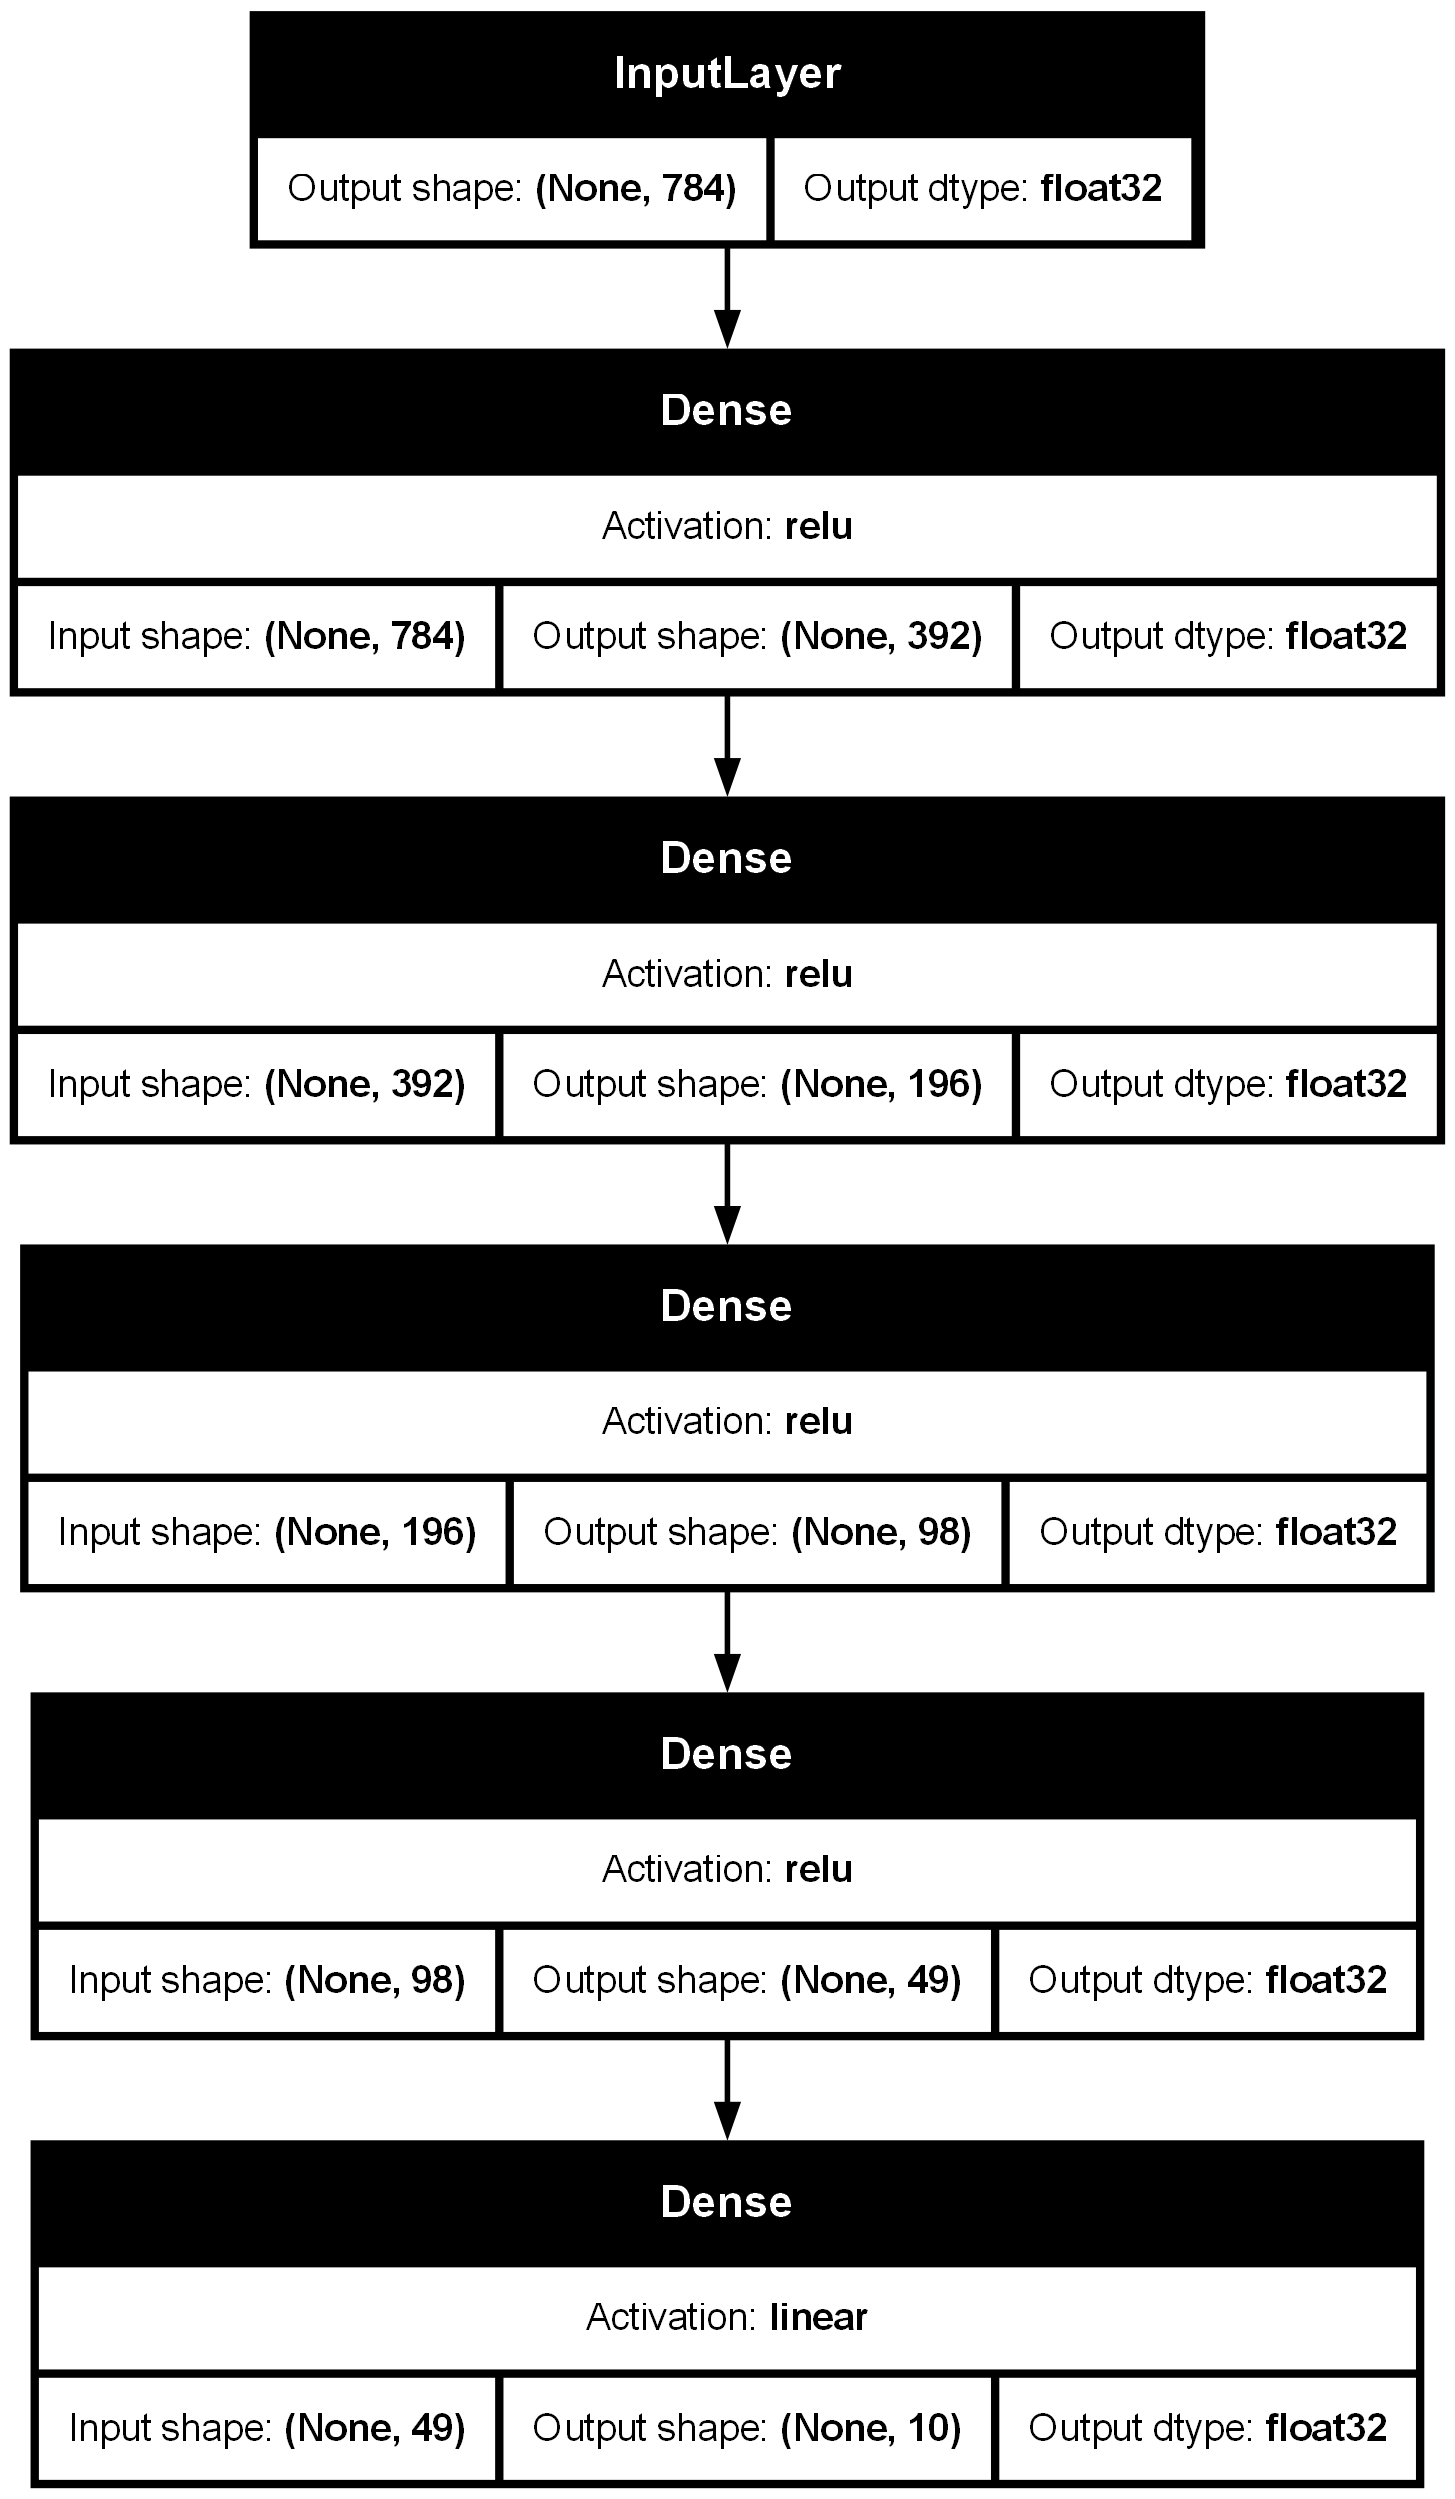

In [66]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [67]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)


# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [68]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7668 - loss: 0.6514 - val_accuracy: 0.8622 - val_loss: 0.3912
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8588 - loss: 0.3865 - val_accuracy: 0.8720 - val_loss: 0.3712
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8762 - loss: 0.3422 - val_accuracy: 0.8695 - val_loss: 0.3663
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8847 - loss: 0.3133 - val_accuracy: 0.8752 - val_loss: 0.3475
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8904 - loss: 0.2971 - val_accuracy: 0.8808 - val_loss: 0.3282
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8954 - loss: 0.2789 - val_accuracy: 0.8759 - val_loss: 0.3358
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9018 - loss: 0.2645 - val_accuracy: 0.8810 - val_loss: 0.3343
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9064 - loss: 0.2515 -

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.816417,0.511323,0.86225,0.391208
1,0.860354,0.384602,0.87200,0.371246
2,0.874979,0.344279,0.86950,0.366311


,accuracy,loss,val_accuracy,val_loss
29,0.948521,0.133099,0.880000,0.506247
30,0.947208,0.137888,0.884833,0.494105
31,0.948500,0.132393,0.878667,0.522811


<Axes: >

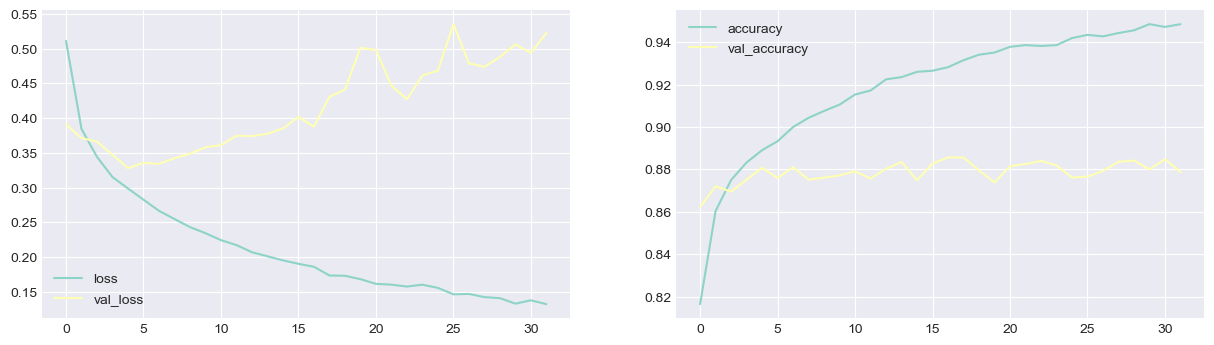

In [69]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fig, axes = plt.subplots(1,2)
hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [70]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.816417,0.511323,0.862250,0.391208
1,0.860354,0.384602,0.872000,0.371246
2,0.874979,0.344279,0.869500,0.366311
3,0.883250,0.315273,0.875167,0.347457
4,0.889063,0.298831,0.880750,0.328167
5,0.893271,0.282758,0.875917,0.335798
6,0.899958,0.266713,0.881000,0.334264
7,0.904312,0.254934,0.875167,0.342461
8,0.907562,0.243268,0.876083,0.348812
9,0.910542,0.234494,0.877167,0.358274


$$\text{
Creating the Prediction Model
}
$$

In [71]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_2 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)


$$
\text{
    If train dataframe is avaliable the only perform following steps 
}
$$

In [72]:
y_pred = model.predict(X_train)
accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


0.929

$$
\text{
Train Data Accuracy and Confusion Matrix
}
$$

In [73]:
y_true, y_pred = [], []
for count, data in enumerate(train_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(48000, 48000)

$$
\text{
Test Data Accuracy and Confusion Matrix
}
$$

In [ ]:
y_true, y_pred = [], []
for count, data in enumerate(test_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(12000, 12000)

In [ ]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8786666666666667

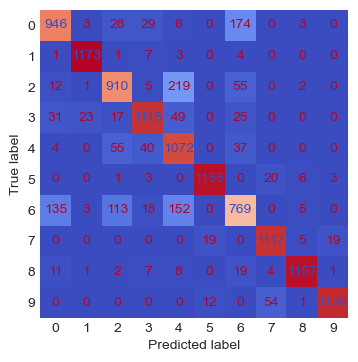

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)

In [74]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.929

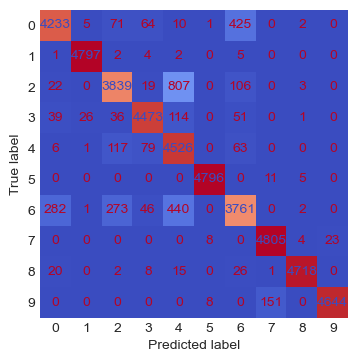

In [75]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)

$$
\text{
Test Data Accuracy and Confusion Matrix
}
$$

In [76]:
y_true, y_pred = [], []
for count, data in enumerate(test_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(12000, 12000)

In [77]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8786666666666667

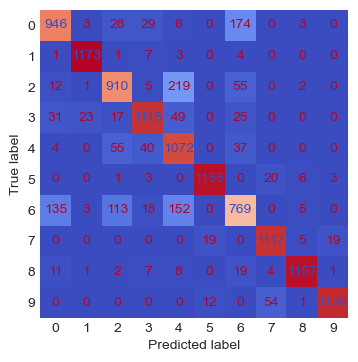

In [78]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)

$$
\text{
Validation Data Accuracy and Confusion Matrix
}
$$

In [79]:
y_true, y_pred = [], []
for count, data in enumerate(valid_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(10000, 10000)

In [80]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8857

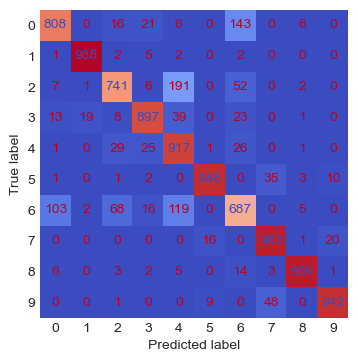

In [81]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)